# Pairs Selection With Unsupervised Learning

In [1]:
from itertools import combinations
from collections import defaultdict, OrderedDict
from math import sqrt

import csv

import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import coint

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")


## Getting the Data

In [2]:
def get_sp500_tickers():
    """Retrieve a list of ticker symbols for all stocks in the S&P 500 index."""
    sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    return sp500['Symbol'].tolist()

def get_stock_data(ticker, start_date, end_date):
    """Fetch historical data for a given stock ticker between specified dates."""
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

def get_sp500_data(start_date, end_date):
    """Fetch historical data for all stocks in the S&P 500 index between specified dates.
    Returns a dict where the key is the stock and the entry is a DF of the results."""
    tickers = get_sp500_tickers()
    sp500_data = OrderedDict()
    for ticker in tqdm(tickers, desc='Fetching data'):
        try:
            data = get_stock_data(ticker, start_date, end_date)
            if len(data) > 0:
                sp500_data[ticker] = data
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    return sp500_data

In [3]:
start_date = "2023-01-01"
end_date = "2023-06-30"
snp500_data = get_sp500_data(start_date, end_date)

[*********************100%%**********************]  1 of 1 completed                             | 0/503 [00:00<?, ?it/s]
[*********************100%%**********************]  1 of 1 completed                     | 1/503 [00:00<03:09,  2.65it/s]
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed                     | 3/503 [00:00<01:29,  5.57it/s]
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed                     | 5/503 [00:00<01:02,  7.95it/s]
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed                     | 7/503 [00:00<00:47, 10.53it/s]
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed                     | 9/503 [00:01<00:47, 10.

In [4]:
def get_sp500_sector_info_dict():
    """Retrieve a dictionary containing ticker symbols as keys and corresponding sectors as 
    values for all stocks in the S&P 500 index."""
    sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    sp500_sector_info_dict = OrderedDict(zip(sp500['Symbol'], sp500['GICS Sector']))
    return sp500_sector_info_dict
    
sp500_sector_info_dict = get_sp500_sector_info_dict()



In [5]:
def check_key1_in_key2(key1, key2) -> list[str]:
    key2_s = set(key2)
    return [k1 for k1 in key1 if k1 not in key2_s]
    
def check_that_keys_match(key1, key2) -> list[str]:
    return check_key1_in_key2(key1, key2), check_key1_in_key2(key2, key1)

check_that_keys_match(sp500_sector_info_dict.keys(), snp500_data.keys())

(['BRK.B', 'BF.B', 'VLTO'], [])

Okay perfect, for every time series, we have the correct data. We will now take that data and create the features that we will train upon.

### Unsupervised Feature Creatation 

So I need some aggrgated features to do the unsupervising learning on. I will use the returns, volatility and the correlation with aggregated baskets from different sectors. 

If I had more time, I would be intrested in trying to find more complex relations between the sectors using LLMs, e.g (https://arxiv.org/pdf/2308.08031.pdf)

#### Sector Baskets

In [6]:
def get_sector_stocks(stock_dict, sector_dict):
    """
    This function takes the stock data dict and the sector dict and returns a dict where
    each value is a list containing the stocks in that sector
    """
    stocks_by_sector = defaultdict(list)
    for stock, stock_data in stock_dict.items():
        sector = sector_dict[stock]
        stocks_by_sector[sector].append(stock_data)
    return stocks_by_sector

In [7]:
def get_sector_aggregate(stocks_by_sector) -> pd.DataFrame:
    """This will take the stocks and create an equally weighted aggregate"""    
    sector_aggregates =  {sector : None for sector in stocks_by_sector.keys()}

    for sector, sector_data in stocks_by_sector.items():
        close_df = pd.DataFrame({i : stock['Close'] for i,stock in enumerate(sector_data)}, index = sector_data[0].index)
        sector_aggregates[sector] = close_df.mean(axis = 1)

    return pd.DataFrame(sector_aggregates, index = sector_data[0].index)
        

In [8]:
sector_stocks = get_sector_stocks(snp500_data, sp500_sector_info_dict)
sector_aggregates = get_sector_aggregate(sector_stocks);

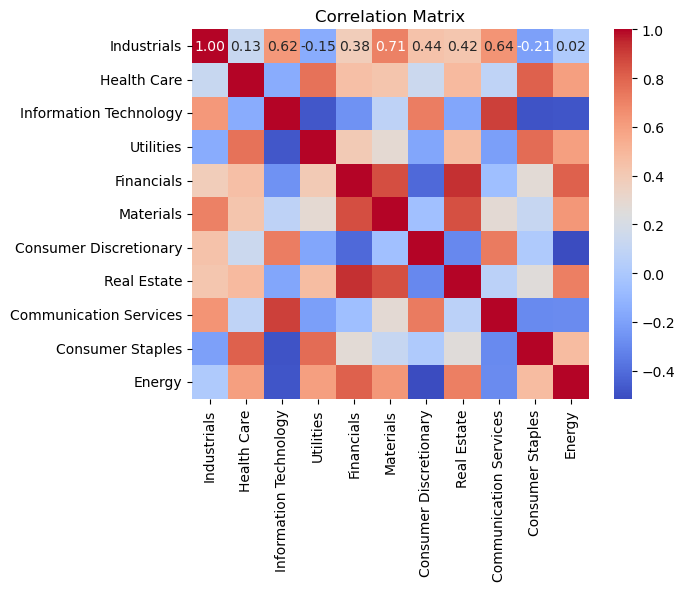

Industrials - Materials: 0.71
Health Care - Utilities: 0.75
Health Care - Consumer Staples: 0.81
Information Technology - Consumer Discretionary: 0.72
Information Technology - Communication Services: 0.9
Utilities - Consumer Staples: 0.77
Financials - Materials: 0.86
Financials - Real Estate: 0.93
Financials - Energy: 0.81
Materials - Real Estate: 0.86
Consumer Discretionary - Communication Services: 0.73
Real Estate - Energy: 0.71


In [9]:
sector_aggreagates_corr = sector_aggregates.corr()

# Plot heatmap
sns.heatmap(sector_aggreagates_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

threshold = 0.7
for i in range(len(sector_aggreagates_corr.columns)):
    for j in range(i+1, len(sector_aggreagates_corr.columns)):
        if sector_aggreagates_corr.iloc[i, j] > threshold:
            print(f"{sector_aggreagates_corr.columns[i]} - {sector_aggreagates_corr.columns[j]}: {np.round(sector_aggreagates_corr.iloc[i, j],2)}")

Okay so there are a few sectors that are well correlated, those that are aren't v surprising. Note that the 
most negatively correlated only have values of -0.5 ish. 

We will now create the features that are correlated with these aggregated baskets

In [10]:
def correlation_with_baskets(basket_time_series, stock_data):
    """Creates a DF with each 'sector_corr' as a column and each index is a stock """
    get_corr_title  = lambda sector : f'{sector} Correlation'
    basket_corr_dict = {get_corr_title(sector) : [] for sector in basket_time_series.keys()} 

    for s_data in stock_data.values():
        for sector, aggregate_data in basket_time_series.items():
            basket_corr_dict[get_corr_title(sector)].append(aggregate_data.corr(s_data['Close']))


    return pd.DataFrame(basket_corr_dict, index = list(stock_data.keys()))

#### Other Features 

We will add two other features to this correlation data: mean annual returns and volitlity. 

In [11]:
def get_daily_returns_vol_data(stocks_data) -> pd.DataFrame:
    """Returns a DF contain the average annual return and vol"""
    returns, volatility = [], []

    for stock_data in stocks_data.values():
        daily_returns = stock_data['Close'].pct_change()
        returns.append(daily_returns.mean() * 266)
        volatility.append(daily_returns.std() * sqrt(266))
        
    return pd.DataFrame({'Average Returns' :returns,
                         'Volatility' : volatility},
                        index = list(stocks_data.keys()))

#### Bringing together all the Features

In [12]:
unsupervised_data = pd.concat([get_daily_returns_vol_data(snp500_data),
                              correlation_with_baskets(sector_aggregates, snp500_data)], axis = 1)
unsupervised_data.head()
unsupervised_data.index

Index(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A',
       ...
       'WTW', 'GWW', 'WYNN', 'XEL', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION',
       'ZTS'],
      dtype='object', length=500)

Okay, so there do seem to be different colour trends depending on which sector we a colouring. I guess that this will help to identify groups. We now just need to scale all the data and then we can get clustering

In [13]:
scaler = StandardScaler()
unsupervised_data = pd.DataFrame(scaler.fit_transform(unsupervised_data), 
                                 columns=unsupervised_data.columns, index = unsupervised_data.index)
unsupervised_data.to_csv('Processed_Feature_Selection_Data.csv', index = True)

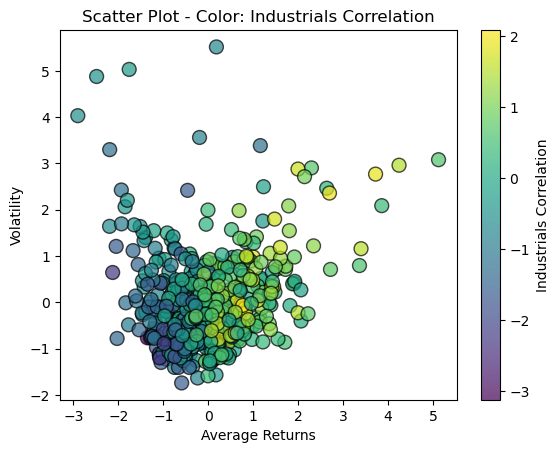

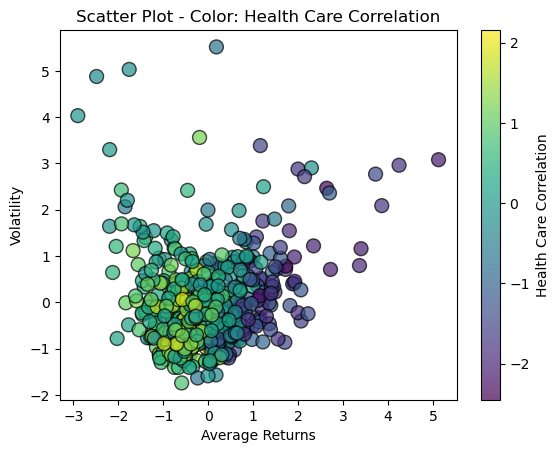

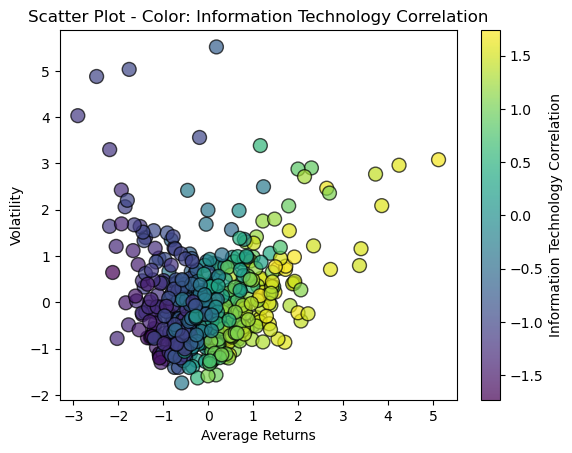

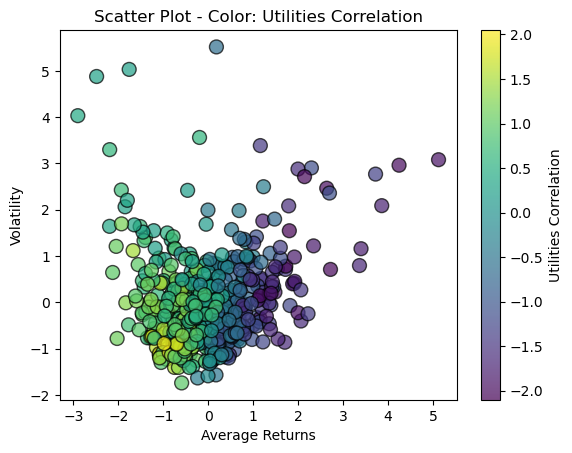

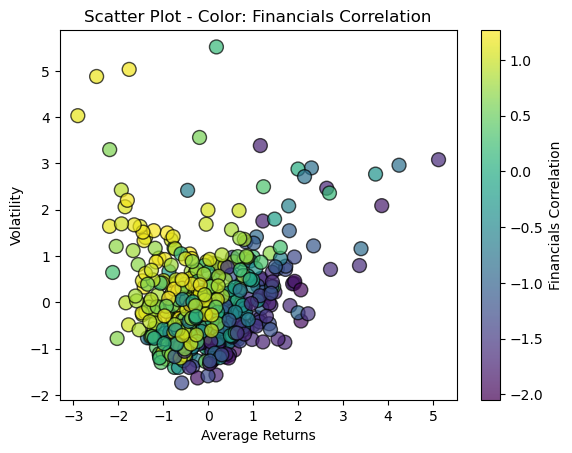

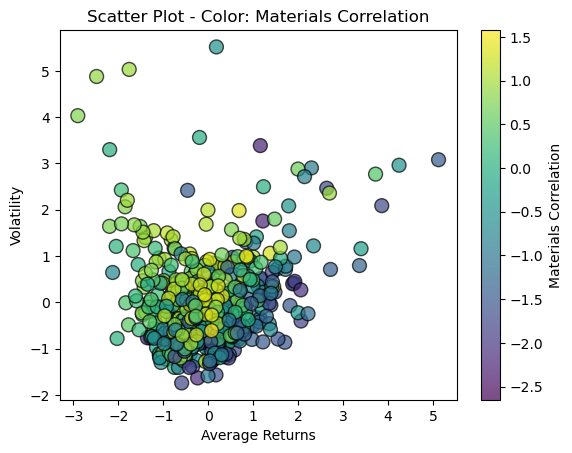

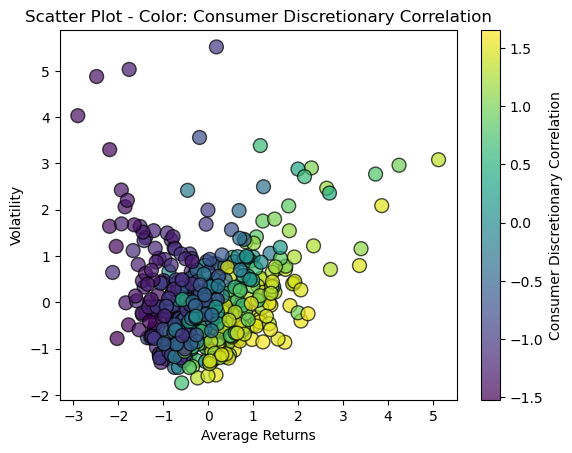

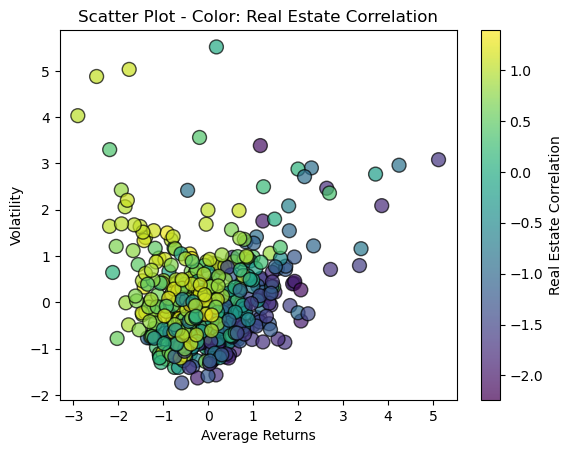

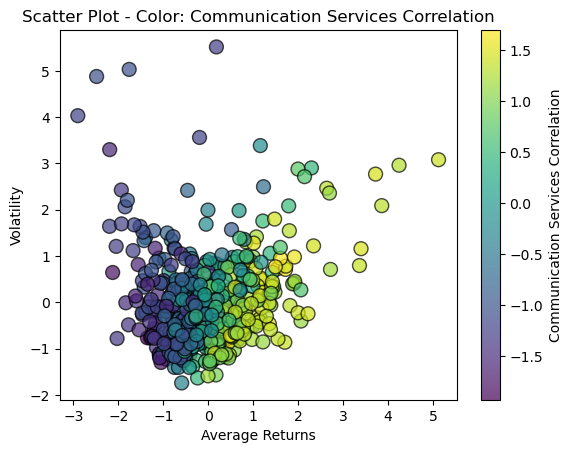

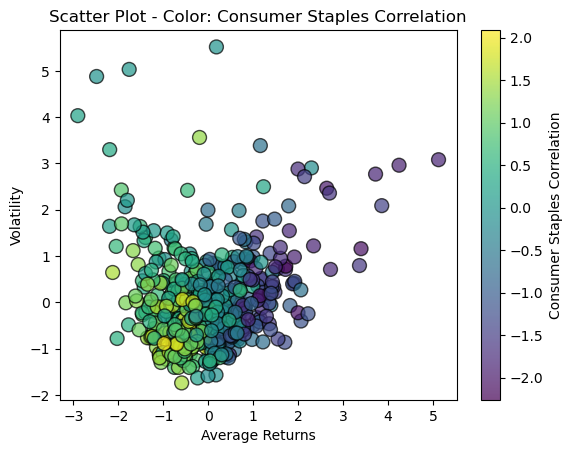

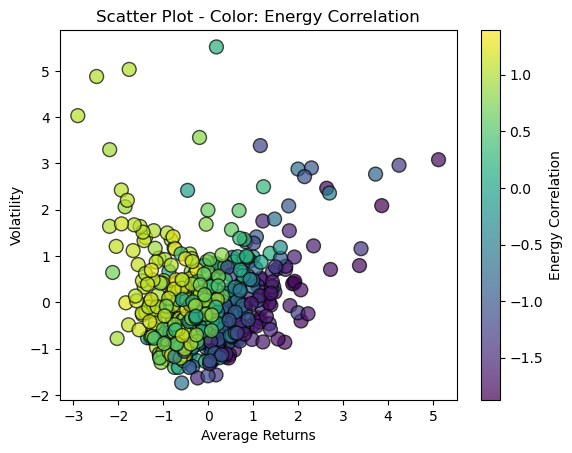

In [14]:
color_columns = unsupervised_data.columns[2:]

for i, column in enumerate(color_columns):
    scatter_plot = unsupervised_data.plot.scatter(x='Average Returns', y='Volatility', c=column, cmap='viridis', s=100, alpha=0.7, edgecolor='k')
    scatter_plot.set_xlabel('Average Returns')
    scatter_plot.set_ylabel('Volatility')
    scatter_plot.set_title(f'Scatter Plot - Color: {column}')
    plt.show()

## Pairs Selection

In [15]:
unsupervised_data = pd.read_csv('Processed_Feature_Selection_Data.csv', index_col = [0])
unsupervised_data.head()

,Average Returns,Volatility,Industrials Correlation,Health Care Correlation,Information Technology Correlation,Utilities Correlation,Financials Correlation,Materials Correlation,Consumer Discretionary Correlation,Real Estate Correlation,Communication Services Correlation,Consumer Staples Correlation,Energy Correlation
MMM,-1.306309,0.007619,-0.941172,0.453561,-1.301341,1.178851,0.867395,0.535047,-1.341069,0.825774,-1.246443,0.654083,1.042228
AOS,0.748710,0.445424,0.985614,-0.988647,1.188659,-1.396058,-1.236135,-1.007345,1.400254,-1.222062,0.876928,-0.617230,-1.552866
ABT,-0.415331,-0.846466,-0.543030,1.333634,-0.558285,1.342269,0.224425,0.327129,0.066185,0.392704,-0.053962,1.119769,0.386438
ABBV,-1.287773,-0.769612,-2.361551,0.499860,-1.411263,0.811534,-0.417639,-1.545005,-0.905074,-0.817450,-1.902419,1.463476,0.359839
ACN,0.339321,-0.347424,1.000011,-0.842148,1.477176,-0.868941,-0.607747,-0.151996,0.828146,-0.533175,1.569108,-1.341993,-0.764154


We will use the following approaches to try and select pairs:

1. **K-means Clustering**:
    - Approach: Partitioning-based
    - Key Idea: Divides the dataset into K clusters by iteratively assigning data points to the nearest cluster centroid and updating the centroids until convergence.
    - Characteristics: Simple and efficient, but sensitive to the initial choice of centroids and may converge to local optima.
2. **Hierarchical Clustering**:
    - Approach: Agglomerative (bottom-up) or divisive (top-down)
    - Key Idea: Builds a hierarchy of clusters by recursively merging or splitting clusters based on the distance between data points.
    - Characteristics: Produces a tree-like structure (dendrogram) representing the relationships between data points and clusters, but can be computationally expensive for large datasets.
3. **Density-based Clustering (DBSCAN)**:
    - Approach: Density-based
    - Key Idea: Groups together data points that are closely packed, forming high-density regions separated by low-density regions, without requiring the number of clusters to be specified in advance.
    - Characteristics: Can handle clusters of arbitrary shape and detect outliers, but sensitive to the choice of distance metric and density parameters.
4. **Gaussian Mixture Models (GMM)**:
    - Approach: Probabilistic
    - Key Idea: Assumes that the data is generated from a mixture of several Gaussian distributions, and uses the Expectation-Maximization (EM) algorithm to estimate the parameters of the Gaussian distributions and assign data points to clusters.
    - Characteristics: Flexible and able to model clusters of different shapes and sizes, but sensitive to the number of components and initialization.



### Clustering 

#### K means Clustering 

Lets do the classic first:

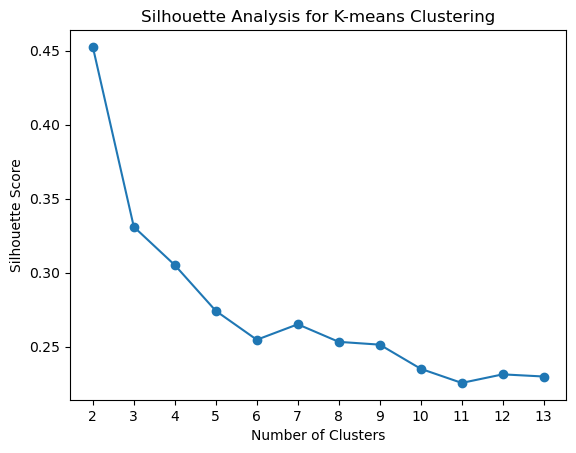

In [16]:
range_n_clusters = range(2, 14)  # Try clusters from 2 to 5

# Compute silhouette scores for each number of clusters
silhouette_scores = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans.fit_predict(unsupervised_data)
    silhouette_avg = silhouette_score(unsupervised_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for K-means Clustering')
plt.xticks(range_n_clusters)
plt.show()

i.e. we want a small number of clusters

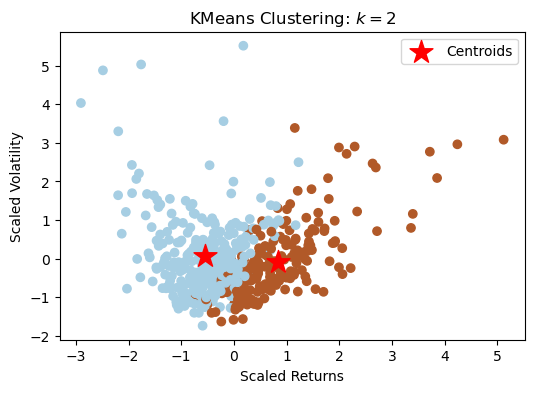

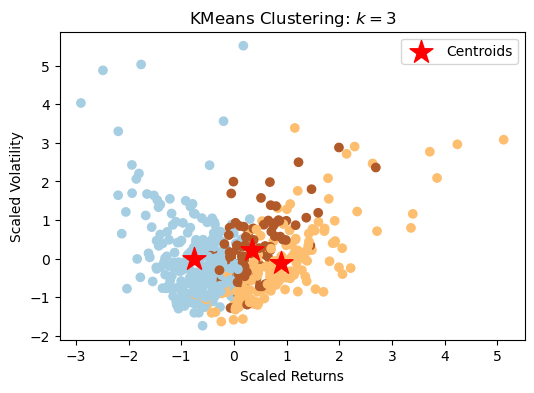

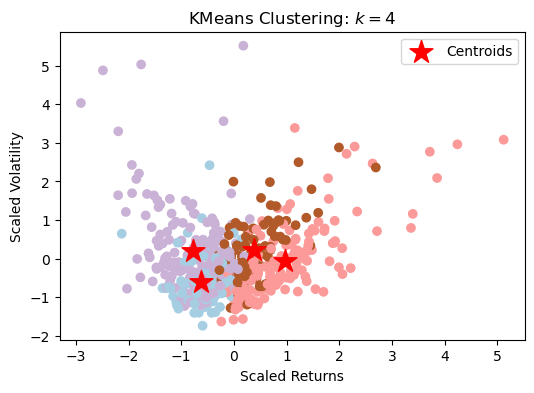

In [17]:
def show_clusters_kmeans(n_clusters, df):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df)
    
    plt.figure(figsize=(6, 4))
    plt.scatter(df['Average Returns'], df['Volatility'], c=kmeans.labels_, cmap=plt.cm.Paired)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='*', s=300,
                c='red', label='Centroids')  # Plot centroids
    plt.xlabel('Scaled Returns')
    plt.ylabel('Scaled Volatility')
    plt.title(f'KMeans Clustering: $k = {n_clusters}$')
    plt.legend()
    plt.show()


show_clusters_kmeans(2, unsupervised_data)
show_clusters_kmeans(3, unsupervised_data)
show_clusters_kmeans(4, unsupervised_data)



Ok, so the silhouette scores are lower than I would have liked, however they are in a high dim space and so we would expect the silhouette scores to be lower than normal. A few other interesting observations:

- Just picking the number of clusters as the number of sectors would give a bad score, in fact we want far fewer clusters than sectors
- In the 2D plane that we plot you see great over lap in the clusters.

Question: Can we explain these groupings by what is in them?

In [18]:
def sectors_in_cluster(n_clusters, df, stock_2_sector_dict):
    kmeans = KMeans(n_clusters=n_clusters)
    cl = kmeans.fit_predict(df)

    cluster_df = pd.DataFrame({'Cluster' : cl, 
                               'Sector' : [stock_2_sector_dict[s] for s in df.index]})
    cluster_count = {}
    for c in range(n_clusters):
        cluster_count[c] = cluster_df[cluster_df['Cluster'] == c].value_counts()
        print(cluster_count[c])
        
sectors_in_cluster(4, unsupervised_data, sp500_sector_info_dict)

Cluster  Sector                
0        Financials                44
         Health Care               20
         Energy                    19
         Industrials               18
         Real Estate               17
         Materials                 16
         Consumer Discretionary    13
         Information Technology     9
         Consumer Staples           8
         Communication Services     6
         Utilities                  3
Name: count, dtype: int64
Cluster  Sector                
1        Industrials               25
         Information Technology    18
         Financials                15
         Consumer Discretionary    14
         Real Estate                9
         Communication Services     6
         Materials                  6
         Health Care                4
         Utilities                  3
         Energy                     1
Name: count, dtype: int64
Cluster  Sector                
2        Information Technology    35
         Industr

Okay, so they clusters seem to be grouping well around sectors, although with different overlap. 

Lets now get the pairings,

In [19]:
kmeans = KMeans(n_clusters=4)
cls = kmeans.fit_predict(unsupervised_data)

grouped_stocks_kmeans = {i : [] for i in range(4)}
for cl, stock in zip(cls,unsupervised_data.index):
    grouped_stocks_kmeans[cl].append(stock)    


#### Hierarchical Clustering

Now lets do some hierarchical clustering.

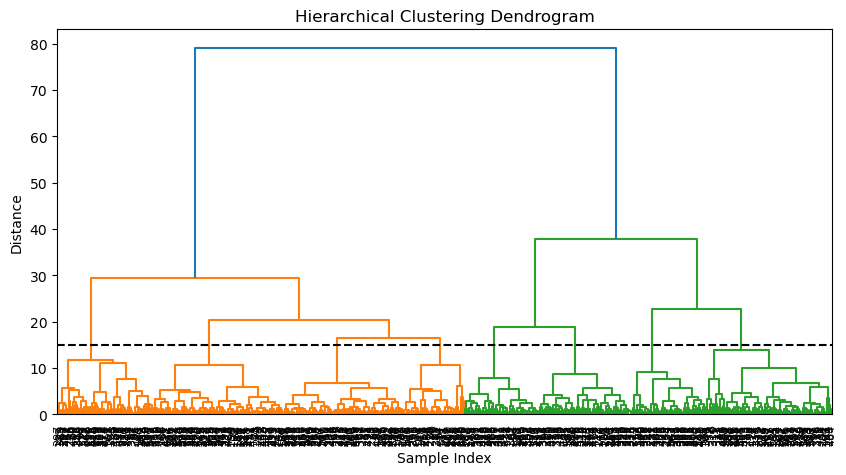

In [20]:
Z = linkage(unsupervised_data, 'ward')

# Plot dendrogram
plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.axhline(15, color = 'black', linestyle ='--')
plt.show()


A note on how to interpretate this (from Chat GPT):

- **Vertical Lines (Branches)**: Each vertical line in the dendrogram represents a cluster at a particular stage of the hierarchical clustering process. The height at which two branches merge indicates the distance at which the clusters were combined.
- **Horizontal Lines (Height)**: The height of each vertical line corresponds to the distance or dissimilarity between the clusters being merged. Lower horizontal lines indicate that the clusters being merged are similar to each other, while higher lines indicate greater dissimilarity.
- **Cluster Similarity**: Clusters that are close to each other on the dendrogram are more similar to each other, while clusters that are farther apart are less similar. The height at which clusters merge can be interpreted as a measure of dissimilarity between the clusters.
- **Grouping and Subgrouping**: As you move from the bottom to the top of the dendrogram, clusters are progressively merged into larger clusters. At each level, you can observe how the clusters are grouped and subgrouped, leading to a hierarchical structure.
- **Cutting the Dendrogram**: You can choose a horizontal line (height threshold) to cut the dendrogram, which results in a specific number of clusters. The choice of the height threshold determines the granularity of the clustering solution.
- **Natural Groupings**: Look for significant gaps or changes in slope in the dendrogram, as these may indicate natural groupings or clusters in your data. These points can guide your choice of height threshold when cutting the dendrogram.

Ultimately you need to choose where to cut this diagram. We pick the horizontal black line as after this the splitting starts to happend v close together. We can plot this on the usual plane

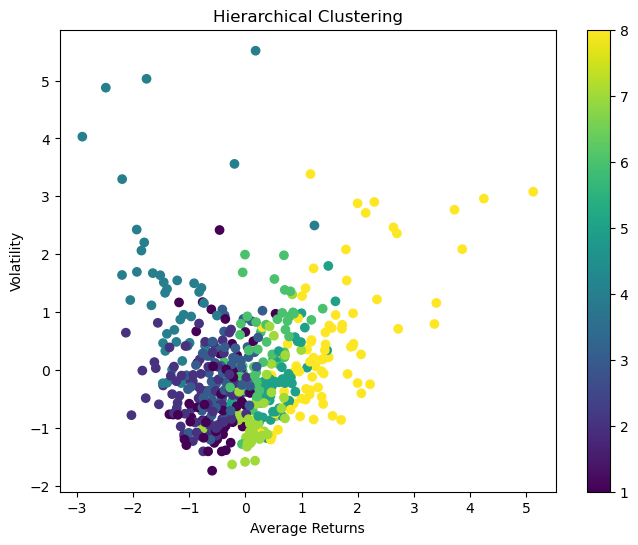

In [21]:
height = 15
clusters = fcluster(Z, height, criterion='distance')

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(unsupervised_data['Average Returns'], unsupervised_data['Volatility'], 
            c=clusters, cmap='viridis')
plt.xlabel('Average Returns')
plt.ylabel('Volatility')
plt.title('Hierarchical Clustering')
plt.colorbar()
plt.show()

In [22]:
grouped_stocks_h = {i : [] for i in range(1, np.max(clusters)+1)}
for cl, stock in zip(clusters,unsupervised_data.index):
    grouped_stocks_h[cl].append(stock) 

#### DBSCAN

In [23]:
def plot_eps_silhouette(X, eps_range, min_samples_range):
    
    for m_s in min_samples_range:
        silhouette_scores = []
        for eps in eps_range:
            dbscan = DBSCAN(eps=eps, min_samples=m_s, algorithm='ball_tree', metric='minkowski', leaf_size = 90, p=2)
            clusters = dbscan.fit_predict(X)
            silhouette_avg = silhouette_score(X, clusters)
            silhouette_scores.append(silhouette_avg)
        
        plt.plot(eps_range, silhouette_scores, marker='o', label = str(m_s))
    plt.xlabel('Epsilon')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score as a Function of Epsilon')
    plt.legend(title = 'min_samples')
    plt.show()

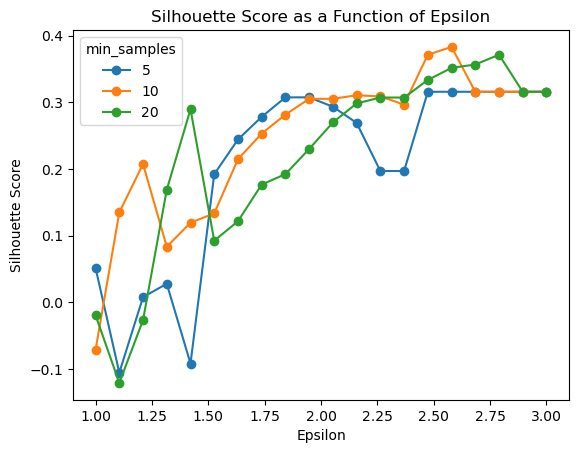

In [24]:
plot_eps_silhouette(unsupervised_data, np.linspace(1, 3, 20), [5,10, 20])

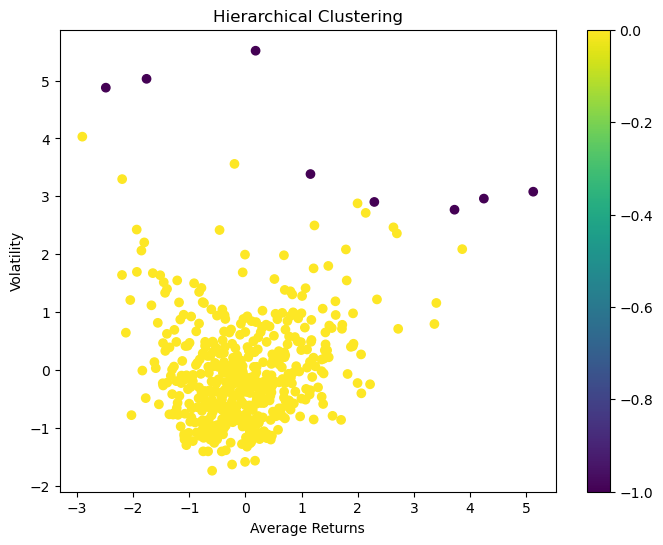

In [25]:
dbscan = DBSCAN(eps=2.5, min_samples=20)
clusters = dbscan.fit_predict(unsupervised_data)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(unsupervised_data['Average Returns'], unsupervised_data['Volatility'], 
            c=clusters, cmap='viridis')
plt.xlabel('Average Returns')
plt.ylabel('Volatility')
plt.title('Hierarchical Clustering')
plt.colorbar()
plt.show()


Okay, so DBSCAN isn't working very well. The reason for this is that the DBSCAN assumes that clusters are well sepereated with areas of low density. In high dim I imagine that this assumpition is a bad one. Therefore it just puts everything in a cluster.

#### GMM 

The best way to find the clusters for GMM is to find the number that minimises the Baysian information criterion (BIC)

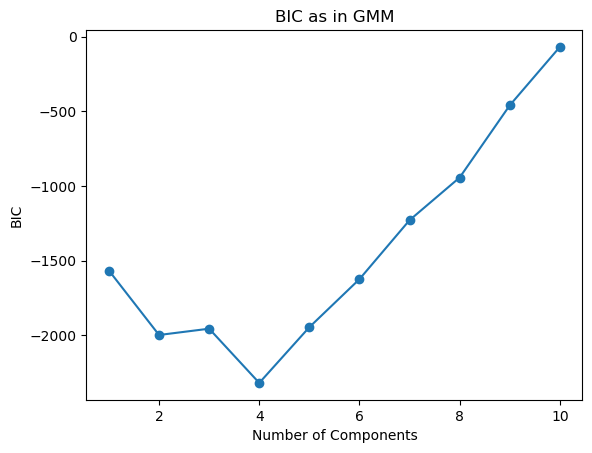

In [26]:
def find_optimal_components_GMM(df, max_components):
    """Fit GMM with different number of components and plot the 
    BIC for each one (lower is better)"""
    n_components_range = range(1, max_components + 1)
    bics = []
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(df)
        bics.append(gmm.bic(df))
    
    # Plot BIC as a function of number of components
    plt.plot(n_components_range, bics, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('BIC')
    plt.title('BIC as in GMM')
    plt.show()

find_optimal_components_GMM(unsupervised_data, 10)

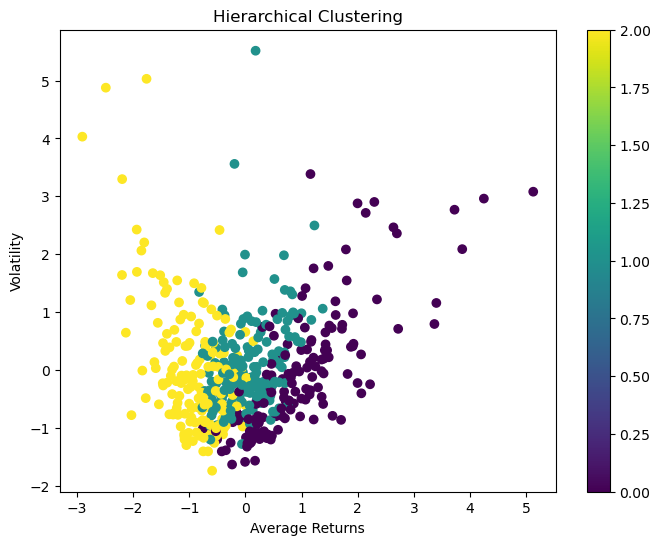

In [27]:
gmm = GaussianMixture(n_components=3)
clusters = gmm.fit_predict(unsupervised_data)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(unsupervised_data['Average Returns'], unsupervised_data['Volatility'], 
            c=clusters, cmap='viridis')
plt.xlabel('Average Returns')
plt.ylabel('Volatility')
plt.title('Hierarchical Clustering')
plt.colorbar()
plt.show()

In [28]:
grouped_stocks_GMM = {i : [] for i in range(0, np.max(clusters)+1)}
for cl, stock in zip(clusters,unsupervised_data.index):
    grouped_stocks_GMM[cl].append(stock) 

## Generate Pairs

So we now need to select the candidate pairs. To do this will will create a set of all the candidates from each clustering method and then take the ones that exist in all the clusters. 

**NB** Please make sure we order the pairs alphabetically, i.e. (AAPl, NVDA) never (NVDA, AAPl)

In [29]:
def from_clusters_2_pairs(cluster_dict):
    """ Takes the cluster list and returns all the pairs formed by stocks in that cluster"""
    pairs = []

    for cluster_stocks in cluster_dict.values():
        stocks_sorted = sorted(cluster_stocks)

        pairs.extend([p for p in combinations(stocks_sorted, 2)]) 

    return set(pairs)

In [30]:
pairs_k = from_clusters_2_pairs(grouped_stocks_kmeans)
pairs_h = from_clusters_2_pairs(grouped_stocks_h)
pairs_g = from_clusters_2_pairs(grouped_stocks_GMM)

unqiue_pairs = list(pairs_k & pairs_h & pairs_g)
print(f"Number of pairs: {len(unqiue_pairs)}")
print(f"Fraction of pairs remaining: {np.round(2*len(unqiue_pairs)/(500*499), 3)}")

Number of pairs: 10774
Fraction of pairs remaining: 0.086


i.e. we have gone from approximately 125,000 to 9,500 candidate pairs. Our next step will be to test if the pairs are cointegrated

In [31]:
with open('Clustering_pairs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(unqiue_pairs)  # Write data rows


## Correlation and Cointergration Test

In [32]:
coint(snp500_data[unqiue_pairs[0][0]]['Close'].values, snp500_data[unqiue_pairs[0][1]]['Close'])

pairs_with_p = []

for i, pair in enumerate(unqiue_pairs):
    if i%1000 == 0:
        print(f"Testing {i}th pair")
    
    if len(snp500_data[pair[0]]['Close']) == len(snp500_data[pair[1]]['Close']):
        _,p,_ = coint(snp500_data[pair[0]]['Close'].values, snp500_data[pair[1]]['Close'].values)
        pairs_with_p.append((pair, p))

Testing 0th pair
Testing 1000th pair
Testing 2000th pair
Testing 3000th pair
Testing 4000th pair
Testing 5000th pair
Testing 6000th pair
Testing 7000th pair
Testing 8000th pair
Testing 9000th pair
Testing 10000th pair


In [33]:
pairs_with_p.sort(key = lambda x : x[1])

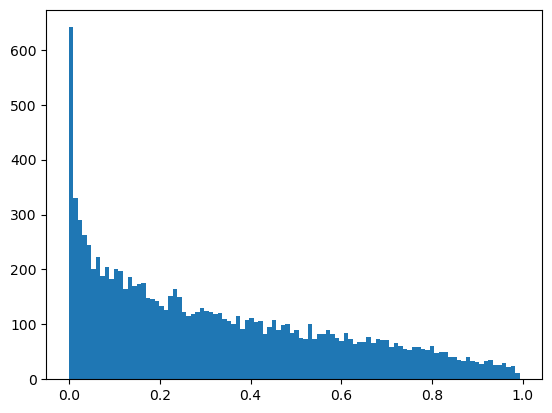

Number of pairs with $p<0.01$;  644
Number of pairs with $p<0.05$;  1773
Number of pairs with $p<0.10$;  2785


In [34]:
plt.hist([v[-1] for v in pairs_with_p],
                               cumulative=False, label="Cumulative histogram", bins =100)
plt.show()
print("Number of pairs with $p<0.01$; ", sum((1 for _, p in pairs_with_p if p <0.01)))
print("Number of pairs with $p<0.05$; ", sum((1 for _, p in pairs_with_p if p <.05)))
print("Number of pairs with $p<0.10$; ", sum((1 for _, p in pairs_with_p if p <.1)))

Okay, if we take our critical $p$ value as 0.01 then we obtain 543 pairs as candidates for pairs trading. Note that this mean the sample of trail pairs are more likly to be conintegrated as we would only expect 90 of random pairs to be cointegrated about this critical value. 

We can now write them to file:

In [35]:
with open('trading_pairs.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([pair for pair, p in pairs_with_p if p <0.01])  # Write data rows

### Graphical Representation of Trading Pairs